# MNIST Handwritten Digits Multi-layer perceptron - Pytorch

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# To tensor & normalize with a mean of 0.5, std of 0.5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

valid_size = 0.2

train_set = datasets.MNIST("./",download = True,train= True,transform=transform)

# Split traing data for validation data
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx = indices[:split]
valid_idx = indices[split:]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_set,batch_size = 20, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_set,batch_size = 20, sampler = valid_sampler)

test_set = datasets.MNIST("./",download = True,train= False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_set,batch_size = 20, shuffle = True)

CUDA is not available.  Training on CPU ...


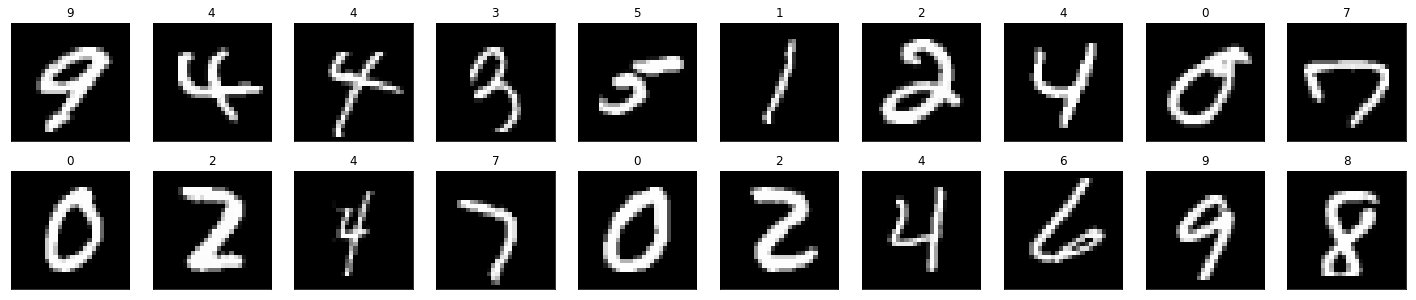

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize data
data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()
fig = plt.figure(figsize=(25,5))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx + 1, xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap = "gray")
    ax.set_title(str(labels[idx].item()))

In [4]:
from torch import nn,optim

# define model class
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim = 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        # makes sure input tensor is flattened
        x = x.view(x.shape[0], - 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [5]:
model = Classifier()
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
  (softmax): LogSoftmax()
  (relu): ReLU()
)


In [6]:
# Since I am returning softmax val, NLL is used instead of CrossEntorypy
#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [7]:
epochs = 30
valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data,label in train_loader:
        
        if train_on_gpu:
            data, label = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    
    with torch.no_grad():
        model.eval()
        for data,label in valid_loader:
            
            if train_on_gpu:
                data, label = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output,label)
            valid_loss += loss.item()*data.size(0)
        
        test_loss = 0
        accuracy = 0
        
        for data,label in test_loader:
            
            if train_on_gpu:
                data, label = data.cuda(), target.cuda()
            
            log_ps = model(data)
            test_loss += criterion(log_ps,label)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1,dim=1)
            equals = top_class == label.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    accuracy = accuracy /len(test_loader) * 100.0
    
    print("Epoch: {} \tTraining Loss: {:.6f} \t Validation Loss {:.6f} \t Accuracy: {:.2f}%".format(
        epoch + 1,train_loss,valid_loss,accuracy))
    
    # saves the best model
    if valid_loss < valid_loss_min:
        torch.save(model.state_dict(),"checkpoint.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.105463 	 Validation Loss 1.442063 	 Accuracy: 61.01%
Epoch: 2 	Training Loss: 1.054434 	 Validation Loss 0.658432 	 Accuracy: 81.29%
Epoch: 3 	Training Loss: 0.671490 	 Validation Loss 0.459625 	 Accuracy: 87.45%
Epoch: 4 	Training Loss: 0.511191 	 Validation Loss 0.405641 	 Accuracy: 88.12%
Epoch: 5 	Training Loss: 0.436276 	 Validation Loss 0.341725 	 Accuracy: 90.52%
Epoch: 6 	Training Loss: 0.386661 	 Validation Loss 0.331712 	 Accuracy: 90.74%
Epoch: 7 	Training Loss: 0.350235 	 Validation Loss 0.292316 	 Accuracy: 91.97%
Epoch: 8 	Training Loss: 0.319828 	 Validation Loss 0.278534 	 Accuracy: 91.99%
Epoch: 9 	Training Loss: 0.293504 	 Validation Loss 0.251062 	 Accuracy: 93.00%
Epoch: 10 	Training Loss: 0.275678 	 Validation Loss 0.240611 	 Accuracy: 93.24%
Epoch: 11 	Training Loss: 0.256784 	 Validation Loss 0.240927 	 Accuracy: 93.54%
Epoch: 12 	Training Loss: 0.236230 	 Validation Loss 0.220540 	 Accuracy: 93.75%
Epoch: 13 	Training Loss: 0.220913 	 

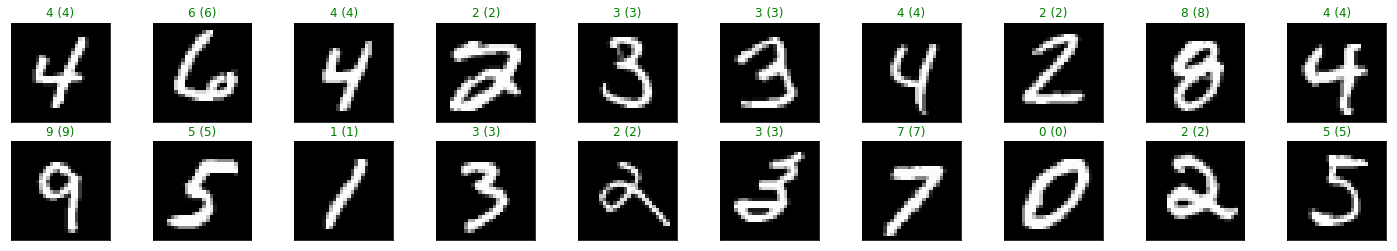

In [8]:
model.eval()
data_iter = iter(test_loader)
images,labels = data_iter.next()
output = model(images)

_, preds = torch.max(output,1)
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx + 1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                color = ("green" if preds[idx] == labels[idx] else "red"))

In [9]:
# Saves the model
#print("My model: \n\n", model,'\n')
#print("The state dict keys: \n\n", model.state_dict().keys())
#torch.save(model.state_dict(),"checkpoint.pth")

In [10]:
# Testing my handwritten digit
best_model = Classifier()
best_model.load_state_dict(torch.load("checkpoint.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

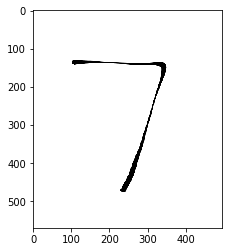

In [16]:
from PIL import Image
from matplotlib.pyplot import imshow
import helper

#1,2,4,7,8
image = Image.open("my_handwriting7.jpg",'r')
imshow(image)
tr = transforms.Compose([transforms.Resize((28,28)), transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
image = tr(image)
image = image.view(1,1,784)

i = 0
for x in image[0][0]:
    if x == 1.0:
        image[0][0][i] = -1.0
    i = i + 1

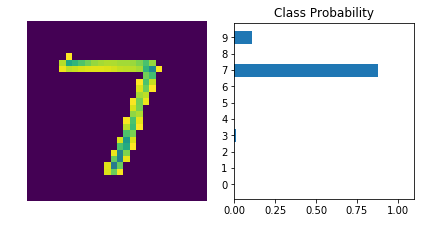

In [17]:
logps = best_model(image)
ps = torch.exp(logps)
helper.view_classify(image.view(1,28,28),ps)

In [15]:
#data_iter = iter(train_loader)
#images, labels = data_iter.next()
#x = model(images[0])
#ps = torch.exp(x)
#helper.view_classify(images[0].view(1,28,28),ps)